# Credit Card Fraud Detection
This notebook will develop a classification model using machine learning techniques on credit card data from Machine Learning Group on Kaggle. It will attempt to identify "fraudulent" and "not fraudulent" credit card transactions.

#### Notes provided by publisher of dataset:
- Data is from credit cards in September 2013 by European cardholders
- The dataset is unbalanced - much more 'not fraud' than 'fraud'. I will go into detail on how I will deal with this throughout the notebook.
- Because of confidentiality issues, V1-V28 are undisclosed features. Time and Amount are the only known features. Class is the response variable (fraud or not fraud).
- V1-V28 have undergone PCA transformation. Time and Amount have not.

In [70]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [40]:
# Read in the data
cc_data = pd.read_csv('creditcards.csv')
# Check the first 5 rows
cc_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Preprocessing

### Summarizing the data
For an initial look at the overall data distribution

In [41]:
cc_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Handling missing values

In [42]:
# Check for nulls
cc_data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

No null values found, so we can move on.

### Scaling the data
I am going to standardize the data so it is suitable for multiple machine learning algorithms. From the information provided with the dataset, I know that V1-V28 have had PCA transformation, so I will only scale Time and Amount. The binary response variable, Class, will not be scaled. 

In [43]:
col_to_scale = ['Time', 'Amount'] 
standard_scaler = StandardScaler()
cc_data[col_to_scale] = standard_scaler.fit_transform(cc_data[col_to_scale])
cc_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


### Dealing with imbalance
This dataset exhibits a substantial class imbalance, with a significantly higher number of non-fraud cases compared to fraud cases. While some machine learning models handle imbalance well, many benefit from a more balanced distribution of data.

First, I will check how imbalanced it is.

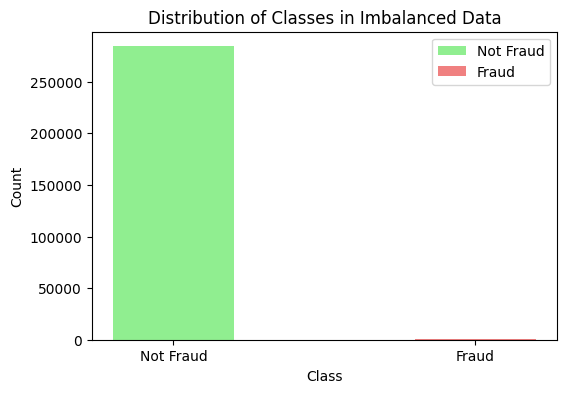

In [44]:
plt.figure(figsize=(6, 4))
plt.hist(cc_data[cc_data['Class'] == 0]['Class'], bins=[-0.2, 0.2], color='lightgreen', label='Not Fraud')
plt.hist(cc_data[cc_data['Class'] == 1]['Class'], bins=[0.8, 1.2], color='lightcoral', label='Fraud')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in Imbalanced Data')
plt.legend()
plt.show()

This data is severely imabalanced. In order to build the most effective model, I will create three distinct datasets: the existing imbalanced dataset, an oversampled dataset, and an undersampled dataset. I'll provide detailed explanations for each approach as I implement them and test multiple models on each. This comprehensive approach will leverage the strengths of various models and evaluate their performance under different data conditions.

#### Splitting into testing and training groups:
Before creating the over/undersampled datasets, I need to have data to train the model and data to evaluate the model. I will use stratified test/train split because of the imbalance.

In [45]:
# Create x and y
cols = cc_data.columns.tolist()
x_cols = [col for col in cols if col != 'Class']
x = cc_data[x_cols]
y = cc_data['Class']
# Use stratified train/test split to preserve class distribution
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

#### Create undersampled dataset:
This involves randomly reducing the number of instances in the majority class (non-fraud) to balance the dataset. The positive of this is that there will be an equal amount of fraud and not-fraud, which is good for training the model. However, we do lose information because it is essentially just removing data. 

In [46]:
# Seperate by majority (not-fraud) and minority (fraud) classes
majority = x_train[y_train == 0]
minority = x_train[y_train == 1]

# Undersample majority class
undersampled_majority = resample(majority, replace=False, n_samples=len(minority), random_state=42)

# Combine undersampled class with the minority. Now we have a balanced dataset
undersampled_x_train = pd.concat([undersampled_majority, minority]) 
undersampled_y_train = pd.Series([0] * len(undersampled_majority) + [1] * len(minority))

# Shuffle the data so the minority and majority classes are mixed while ensuring the rows still match up
undersampled_x_train = undersampled_x_train.sample(frac=1, random_state=42).reset_index(drop=True)
undersampled_y_train = undersampled_y_train.sample(frac=1, random_state=42).reset_index(drop=True)

Check the undersampled distribution: 

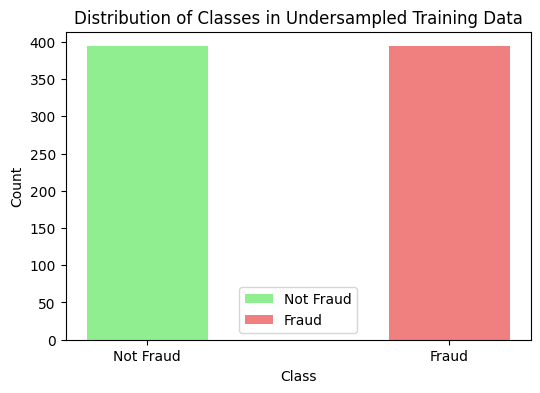

In [47]:
plt.figure(figsize=(6, 4))
plt.hist(undersampled_y_train[undersampled_y_train == 0], bins=[-0.2, 0.2], color='lightgreen', label='Not Fraud')
plt.hist(undersampled_y_train[undersampled_y_train == 1], bins=[0.8, 1.2], color='lightcoral', label='Fraud')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in Undersampled Training Data')
plt.legend()
plt.show()

The data is evenly distributed with almost 350 observations in each class. 

#### Create oversampled dataset:
This involves artificially increasing the number of instances in the minority class (fraud) to balance the dataset. Instead of doing it randomly, I will use the Synthetic Minority Oversampling Technique (SMOTE), which looks at examples of the minority class and creates new ones that are similar to balance the dataset. This technique effectively increases the number of minority class samples, providing the model with more data to learn from. While SMOTE is a powerful and safe oversampling method, it's essential to note that it may lead to some overlap between the majority and minority classes.

In [48]:
smote = SMOTE(random_state=42)
oversampled_x_train, oversampled_y_train = smote.fit_resample(x_train, y_train)
# Shuffle data
oversampled_x_train = oversampled_x_train.sample(frac=1, random_state=42).reset_index(drop=True)
oversampled_y_train = oversampled_y_train.sample(frac=1, random_state=42).reset_index(drop=True)

Check the oversampled distribution:

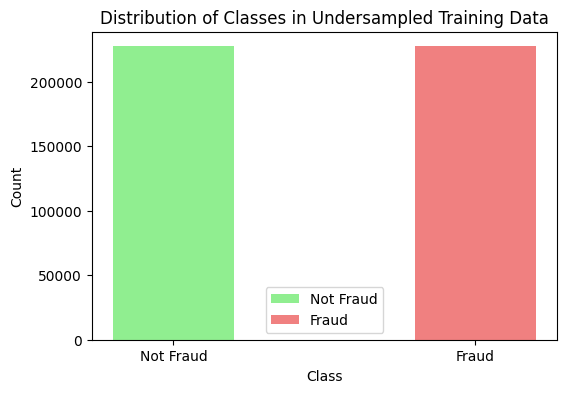

In [49]:
plt.figure(figsize=(6, 4))
plt.hist(oversampled_y_train[oversampled_y_train == 0], bins=[-0.2, 0.2], color='lightgreen', label='Not Fraud')
plt.hist(oversampled_y_train[oversampled_y_train == 1], bins=[0.8, 1.2], color='lightcoral', label='Fraud')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in Undersampled Training Data')
plt.legend()
plt.show()

The data is evenly distrubited with almost 20,000 instances in each class. 

# Making the Models
First, a class containing 3 functions, one for each model (XGBoost, Logistic Regression, and MLPClassifer Neural Network). I chose these models because they all work differently and I want to test a diverse model selection. In my initial testing, I will use default parameters and all variables to get a baseline understand. Using the initial results, I will perform further feature engineering and hyperparameter tuning. 

In [50]:
class Models:

    # This function trains an xgboost model
    @staticmethod
    def xgboost_model(x_train, y_train):
        model = XGBClassifier()
        model.fit(x_train, y_train)
        return model

    # This function trains a Logistic Regression
    @staticmethod
    def logistic_regression(x_train, y_train): 
        model = LogisticRegression(max_iter=1000)
        model.fit(x_train, y_train)
        return model

    # This function trains a Neural Network
    def neural_network(x_train, y_train):
        model = MLPClassifier(max_iter=1000)
        model.fit(x_train, y_train)
        return model

Another class for scoring. My primary scoring metric will be AUPRC because it is well-suited for imbalanced data, as advised by Machine Learning Group on Kaggle. I will also use the classification report for further insight at some points of testing. 

In [51]:
class Scoring:
    @staticmethod
    def test_and_score(x_train, y_train, x_test, y_test, model_choice: str):
        # Train the appropriate model
        if model_choice == 'XGB':
            model = Models.xgboost_model(x_train, y_train)
        elif model_choice == 'LR':
            model = Models.logistic_regression(x_train, y_train)
        elif model_choice == 'NN':
            model = Models.neural_network(x_train, y_train)
        else:
            print("Invalid model. Try again with 'XGB', 'LR', or 'NN'")
            return None

        # Get predicted probabilities
        y_scores = model.predict_proba(x_test)[:, 1]

        # Threshold predictions to get binary labels
        y_pred = (y_scores >= 0.5).astype(int)

        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        auprc = auc(recall, precision)

        cr = classification_report(y_test, y_pred)

        # Put scores in a list to return
        scores = [cr, auprc]

        return scores

    # This function makes a visual of the precision-recall curve using scores in list form as returned the function above
    @staticmethod
    def plot_pr_curve(scores: list):
        precision, recall, auprc = scores  # Extract precision, recall, and auprc from the scores list

        # Plot the Precision-Recall Curve
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, color='blue', lw=2, label=f'AUPRC = {auprc:.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()

#### XGBoost AUPRC: 

In [52]:
imbalanced_scores = Scoring.test_and_score(x_train, y_train, x_test, y_test, 'XGB')
undersampled_scores = Scoring.test_and_score(undersampled_x_train, undersampled_y_train, x_test, y_test, 'XGB')
oversampled_scores = Scoring.test_and_score(oversampled_x_train, oversampled_y_train, x_test, y_test, 'XGB')
print(f'Imbalanced Data AUPRC: {imbalanced_scores[1]}\nUndersampled Data AUPRC: {undersampled_scores[1]}\n'
      f'Oversampled Data AUPRC: {oversampled_scores[1]}')

Imbalanced Data AUPRC: 0.8775604254615612
Undersampled Data AUPRC: 0.3686462293346371
Oversampled Data AUPRC: 0.8611198060157895


#### Logistic Regression AUPRC: 

In [125]:
imbalanced_scores = Scoring.test_and_score(x_train, y_train, x_test, y_test, 'LR')
undersampled_scores = Scoring.test_and_score(undersampled_x_train, undersampled_y_train, x_test, y_test, 'LR')
oversampled_scores = Scoring.test_and_score(oversampled_x_train, oversampled_y_train, x_test, y_test, 'LR')
print(f'Imbalanced Data AUPRC: {imbalanced_scores[1]}'
      f'\nUndersampled Data AUPRC: {undersampled_scores[1]}\n'
      f'Oversampled Data AUPRC: {oversampled_scores[1]}')

Imbalanced Data AUPRC: 0.742315030624464
Undersampled Data AUPRC: 0.7006060696920684
Oversampled Data AUPRC: 0.7839963107835599


#### Neural Network AUPRC:

In [126]:
imbalanced_scores = Scoring.test_and_score(x_train, y_train, x_test, y_test, 'NN')
undersampled_scores = Scoring.test_and_score(undersampled_x_train, undersampled_y_train, x_test, y_test, 'NN')
oversampled_scores = Scoring.test_and_score(oversampled_x_train, oversampled_y_train, x_test, y_test, 'NN')
print(f'Imbalanced Data AUPRC: {imbalanced_scores[1]}\nUndersampled Data AUPRC: {undersampled_scores[1]}\n'
      f'Oversampled Data AUPRC: {oversampled_scores[1]}')

Imbalanced Data AUPRC: 0.870726669654103
Undersampled Data AUPRC: 0.6671017028737332
Oversampled Data AUPRC: 0.7759166125739732


### Takeways from scores:
- XGBoost had the highest AUPRC with all subsets of data.
- XGBoost and Logistic Regression were the fastest. Neural Network was very slow.
- The imbalanced data and oversampled data performed significantly better than the undersampled data with every model.
### Next Steps:
I will continue hyperparameter tuning and feature engineering with only the XGBoost model due to its superior performance in both speed and accuracy. While I believe the neural network has potential, its computational demands were high, and it still did not match XGBoost's performance. All models had considerably worse scores with the undersampled data, so I will continue investigating with only the imbalanced and oversampled data. 

# More Feature Engineering on XGBoost

### Check feature importances:
XGBoost has a feature that calculates how important each feature was to its predictions. I will make a barchart to visualize these for all of the variables.

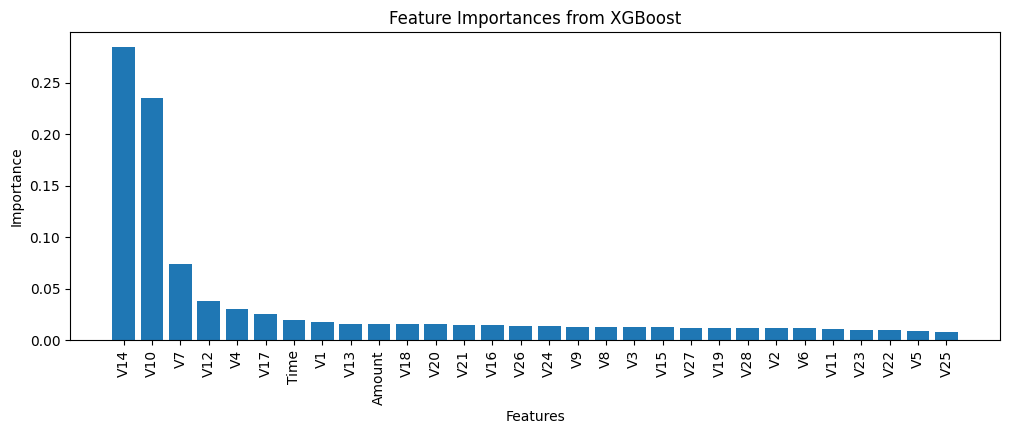

In [53]:
# Get model
xgb = Models.xgboost_model(x_train, y_train)
# Get feature importances
feature_importances = xgb.feature_importances_
# Create a dictionary mapping feature names to their importance scores
feature_names = x_train.columns.tolist()
feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, feature_importances)}
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))
# Create a bar plot to visualize feature importances
plt.figure(figsize=(12, 4))
plt.bar(sorted_feature_importance.keys(), sorted_feature_importance.values())
plt.xticks(rotation='vertical')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances from XGBoost")
plt.show()

Now, I will test the same model with the top features and see if it improves. 

In [54]:
top_features = [feature for feature, importance in sorted_feature_importance.items()][:21]
imbalanced_scores = Scoring.test_and_score(x_train[top_features], y_train, x_test[top_features], y_test, 'XGB')
oversampled_scores = Scoring.test_and_score(oversampled_x_train[top_features], oversampled_y_train, x_test[top_features], 
                                            y_test, 'XGB')
print(f'Imbalanced Data AUPRC: {imbalanced_scores[1]}\nOversampled Data AUPRC: {oversampled_scores[1]}')

Imbalanced Data AUPRC: 0.8779814280371803
Oversampled Data AUPRC: 0.8548329546336549


I tested this many times, changing the number of top features included. The model did not noticably improve with less features, so for now, I will continue with all features included. 

### Find correlations:
I did not find that only including a certain amount of top features improved the model, but there could be certain top features that are highly correlated. Removing highly correlated variables can reduce the risks of multicollinearity by improving model stability and interpretability. 

I will make a correlation matrix heatmap for both the imbalanced data and the oversampled data to get an understanding of both.

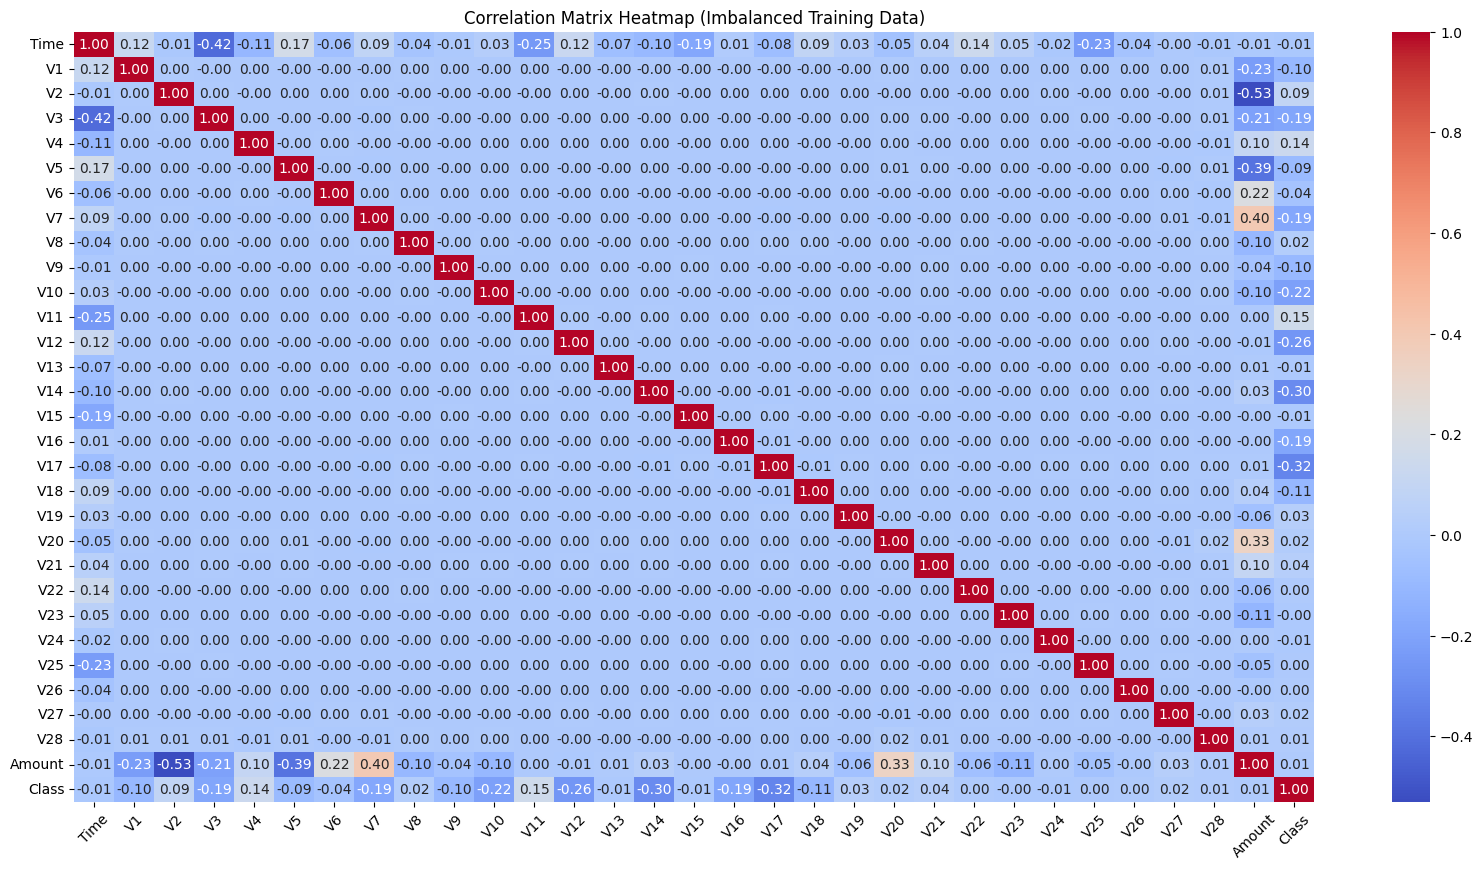

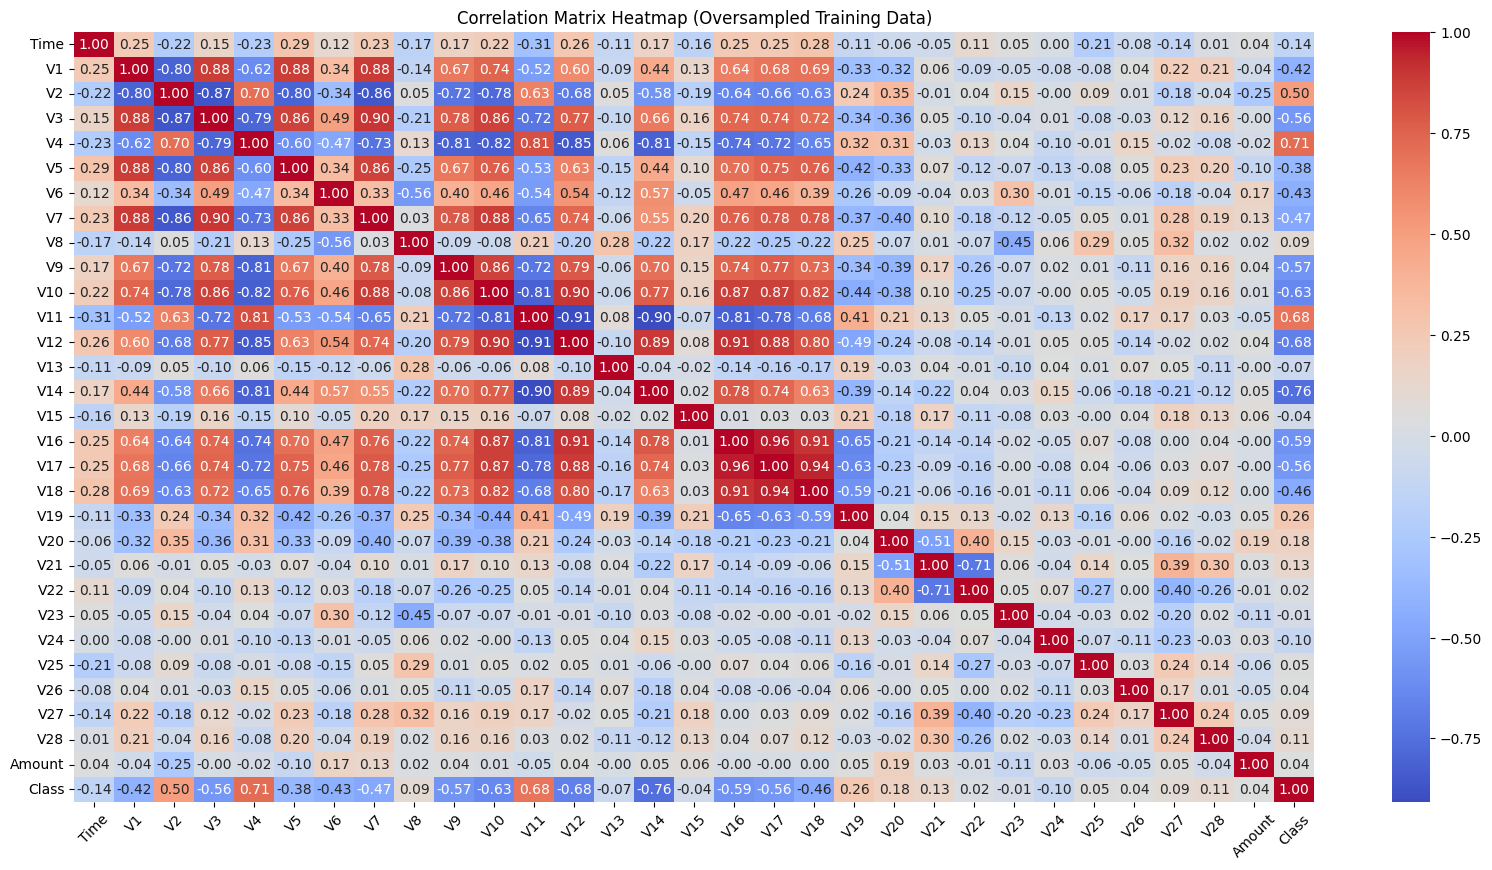

In [55]:
# Add the response variable so we can get tose correlations as well
combined_imbalanced = pd.concat([x_train, y_train], axis=1)
combined_oversampled = pd.concat([oversampled_x_train, oversampled_y_train], axis=1)
# Get correlations
imbalanced_corr_mx = combined_imbalanced.corr()
oversampled_corr_mx = combined_oversampled.corr()

# Create a heatmap for the imbalanced correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(imbalanced_corr_mx, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap (Imbalanced Training Data)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Create a heatmap for the oversampled correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(oversampled_corr_mx, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap (Oversampled Training Data)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

#### Correlation Takeaways:
- The imbalanced dataset had no strong correlations to worry about. The oversampled data has plenty of correlations in the top left.
- Positive correlations with class: V2, V4, V11
- Negative correlations with class: V3, V9, V10, V12, V14, V16, V17
- I noticed that all of these variables in the positive correlations each have strong correlations with each other, and same for the negatives.

To address this further, I will first attempt to remove some of the correlated features. For example, V4 and V2 are both positively correlated with class and positively correlated with each other, so I will remove V2 because it is the weaker correlation with class. 

In [56]:
col_to_remove = ['V2', 'V11', 'V3', 'V9', 'V17']
cols = [col for col in x_train.columns.tolist() if col not in col_to_remove]
imbalanced_scores = Scoring.test_and_score(x_train[cols], y_train, x_test[cols], y_test, 'XGB')
oversampled_scores = Scoring.test_and_score(oversampled_x_train[cols], oversampled_y_train, x_test[cols], 
                                            y_test, 'XGB')
print(f'Imbalanced Data: {imbalanced_scores[1]}\nOversampled Data: {oversampled_scores[1]}')

Imbalanced Data: 0.8787581919902452
Oversampled Data: 0.8624868658463601


The performance did not noticeably improve for either dataset. 

Another way to use the correlations is to remove some harmful outliers, as observed in Janio Martinez Bachmann's notebook in Kaggle. This method removes extreme outliers from highly correlated features. I will adopt this general strategy, but use my own approach based on my statistics knowledge.

The threshold for outliers is outside +- 1.5*IQR, so this is what I will use to remove outliers. The 1.5 multiplier might change throughout testing to see what works best. Changing the multiplier will either make a higher or lower barrier which can increase or decrease the amount of data removed.

Note: This will only be done with the oversampled data. It does not make sense to remove outliers from the imbalanced data because there are so few 'frauds' that many of them are probably outliers and we would be losing too much information

In [57]:
def remove_outliers(x_train, y_train, columns, multiplier):
    outlier_indices = []

    for column in columns:
        # Extract the data from the specified column
        data = x_train[column]
        # Calculate the IQR
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        # Find the lower and upper bounds for outliers
        lower_bound = q1 - multiplier * iqr
        upper_bound = q3 + multiplier * iqr
        # Identify the indices of outliers in x_train
        outliers_indices_column = (data < lower_bound) | (data > upper_bound)
        outlier_indices.extend(x_train[outliers_indices_column].index.tolist())

    # Remove duplicate indices (if any)
    outlier_indices = list(set(outlier_indices))

    # Remove outliers from x_train using .loc indexer
    x_train = x_train.loc[~x_train.index.isin(outlier_indices)]

    # Remove corresponding rows from y_train using .loc indexer
    y_train = y_train.loc[~y_train.index.isin(outlier_indices)]

    return x_train, y_train

In [58]:
cols_to_filter = ['V4', 'V11','V14', 'V12', 'V16']
filtered_oversampled_x_train, filtered_oversampled_y_train = remove_outliers(oversampled_x_train, 
                                                                             oversampled_y_train, cols_to_filter, 2.0)

In [59]:
oversampled_scores = Scoring.test_and_score(filtered_oversampled_x_train, filtered_oversampled_y_train, 
                                            x_test, y_test, 'XGB')
print(f'Oversampled Data Classification Report:\n{oversampled_scores[0]}')
print(f'Oversampled Data AUPRC: {oversampled_scores[1]}')

Oversampled Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.87      0.79        98

    accuracy                           1.00     56962
   macro avg       0.87      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Oversampled Data AUPRC: 0.8710522639383688


The AUPRC score of the oversampled data improved by over 1%. This is not a dramatic increase, but the we started out with a score of above 0.8 already, so I don't expect huge jumps in score. The increase is enough to continue using the filtered data without outliers. 

# Hyperparameter Tuning
When I ran my model earlier, I used the default parameters of XGBoost. By using custom parameters, we may get better results. I will use Bayesian Optimization to determine the optimal parameters and test the results. The decision to do this type of tuning and how I performed it came from extensive research into articles, like 'Grid Search VS Random Search VS Bayesian Optimization' by Aashish Nair, and sklearn documentation. 

#### Imbalanced Data Tuning
 First, I will run it with the imbalanced data, then I will do the same thing with the oversampled data.

In [205]:
# Define a AUPRC scoring function
def auprc_scorer(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auprc = auc(recall, precision)
    return auprc

# Create an instance of XGBClassifier
xgb = XGBClassifier()

# Define the parameter search space
param_space = {
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'max_depth': (3, 6),
    'n_estimators': (100, 300),
    'subsample': (0.8, 1.0),
    'colsample_bytree': (0.8, 1.0)
}

# Create a BayesSearchCV object with verbose set to 0 (no printing)
bayes_search = BayesSearchCV(
    xgb,
    param_space,
    scoring=make_scorer(auprc_scorer, greater_is_better=True),
    cv=5,
    n_jobs=-1,
    n_iter=50,  
    verbose=0
)

# Fit the search to your data
bayes_search.fit(x_train, y_train)

# Get the AUPRC scores over time
results = pd.DataFrame(bayes_search.cv_results_)

# Get the best hyperparameters and estimators
best_params = bayes_search.best_params_
best_estimator = bayes_search.best_estimator_

# Print the best hyperparameters and best AUPRC score
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"Best AUPRC: {bayes_search.best_score_}")

Best Hyperparameters:
colsample_bytree: 0.9726231632086542
learning_rate: 0.0849829944742174
max_depth: 5
n_estimators: 299
subsample: 0.9721182219895957
Best AUPRC: 0.874346142863715


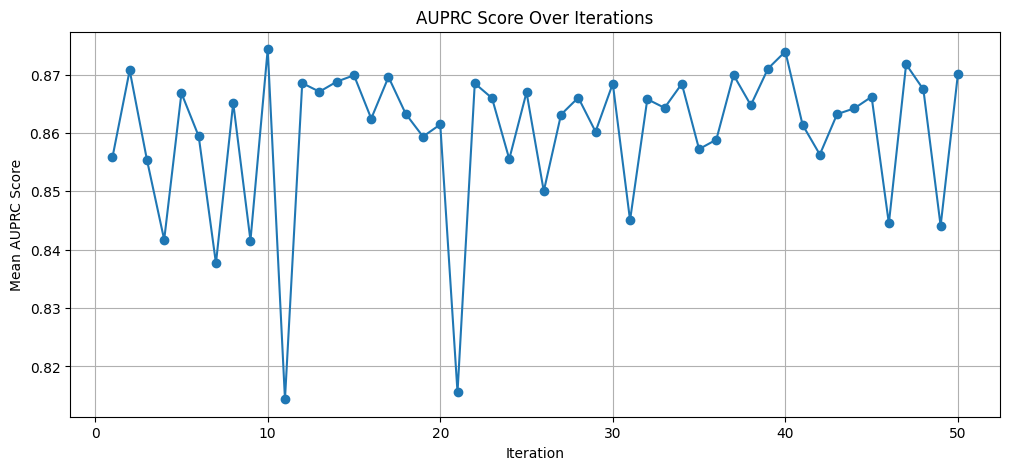

In [207]:
# Plot the AUPRC scores over time
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(results) + 1), results["mean_test_score"], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Mean AUPRC Score")
plt.title("AUPRC Score Over Iterations")
plt.grid(True)
plt.show()

The optimizaiton seems to have found a good hyperparameters that produce improved results. 

I will test the optimized hyperparameters on the test data now because that is what I have been using for scoring thus far. I may slightly change some of the parameters intuitively to see if results improve.

In [60]:
# Create and train your XGBoost classifier
model = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=5,
    n_estimators=204,
    subsample=0.8
)

col_to_remove = ['V2', 'V11', 'V3', 'V9', 'V17']
cols = [col for col in x_train.columns.tolist() if col not in col_to_remove]
model.fit(x_train[cols], y_train)

# Predict on your test data
y_pred = model.predict(x_test[cols])

# Calculate the AUPRC score on the test data
auprc_score = auprc_scorer(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(f"AUPRC Score on Test Data: {auprc_score}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.83      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC Score on Test Data: 0.8843447609691317


The AUPRC score for the imbalanced data improved slightly compared to default parameters - the hyperparameter tuning was a success for the imbalanced data. 

#### Oversampled Data Tuning
Now, I will run it with the oversampled data.

In [165]:
xgb = XGBClassifier()
# Define the parameter search space
param_space = {
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'max_depth': (3, 6),
    'n_estimators': (100, 300),
    'subsample': (0.8, 1.0),
    'colsample_bytree': (0.8, 1.0),
    'reg_alpha': (0.01, 10.0, 'log-uniform'),
    'reg_lambda': (0.01, 10.0, 'log-uniform')  
}

# Create a BayesSearchCV object
bayes_search = BayesSearchCV(
    xgb,
    param_space,
    scoring=make_scorer(auprc_scorer, greater_is_better=True),
    cv=5,
    n_jobs=-1,
    n_iter=100,  # Adjust the number of iterations
    verbose=0,
)

# Fit the search to my data
bayes_search.fit(filtered_oversampled_x_train, filtered_oversampled_y_train)
# Get the AUPRC scores over time
results = pd.DataFrame(bayes_search.cv_results_)
# Get the best hyperparameters and estimators
best_params = bayes_search.best_params_
best_estimator = bayes_search.best_estimator_
# Print the best hyperparameters and best AUPRC score
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"Best AUPRC: {bayes_search.best_score_}")

Best Hyperparameters:
colsample_bytree: 0.8
learning_rate: 0.13116343179094353
max_depth: 6
n_estimators: 300
reg_alpha: 0.01
reg_lambda: 0.01
subsample: 0.8
Best AUPRC: 0.9997617585729287


In [178]:
# Check the first occurances of the top results
results[results['rank_test_score'] == 1].head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,29.961178,0.263173,1.055427,0.107588,0.8,0.131163,6,300,0.01,0.01,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.99972,0.999748,0.999748,0.99972,0.999874,0.999762,0.000057,1


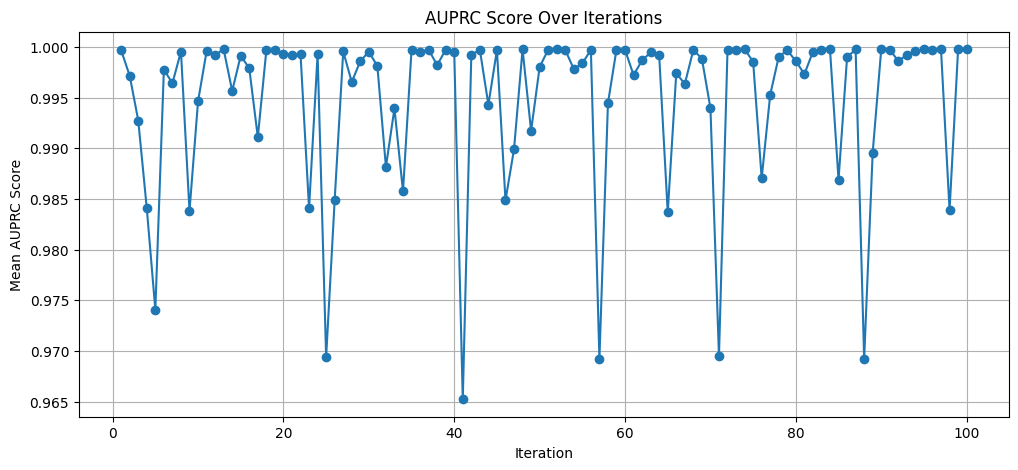

In [158]:
# Plot the AUPRC scores over time
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(results) + 1), results["mean_test_score"], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Mean AUPRC Score")
plt.title("AUPRC Score Over Iterations")
plt.grid(True)
plt.show()

From this, I can tell that the model completely overfit the training data.

In [61]:
# Create and train your XGBoost classifier
model = XGBClassifier(
    colsample_bytree= 0.8,
    learning_rate= 0.1312,
    max_depth= 6,
    n_estimators= 300,
    reg_alpha= 0.01,
    reg_lambda= 0.01,
    subsample= 0.8
)
model.fit(filtered_oversampled_x_train, filtered_oversampled_y_train)

# Predict on your test data
y_pred = model.predict(x_test)

# Calculate the AUPRC score on the test data
auprc_score = auprc_scorer(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(f"AUPRC Score on Test Data: {auprc_score}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.85      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC Score on Test Data: 0.8043349994344158


The model's performance did not benefit from adjusted hyperparameters compared to using the default settings. It is evident that the model exhibited overfitting during the optimization process, possibly due to the utilization of SMOTE oversampling. The SMOTE process generated synthetic samples that closely resembled the positive instances within the dataset. It's conceivable that the Bayesian optimization process was able to recognize this similarity during training and cross-validation. This potential issue did not occur earlier because my prior evaluation relied on a separate dataset for scoring. However, with hyperparameter tuning employing cross-validation, the model is now being tested with these synthetic samples.

To test if this is the case, I will run the same optimization, but score on the test data instead of cross-validation. I am not aware of how to perform this within bayesian optimization, so I will have to make my own that tests random parameters, operating similarly to random search optimization. 

In [73]:
# Define a custom AUPRC scoring function
def auprc_scorer(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auprc = auc(recall, precision)
    return auprc

# Initialize variables to keep track of the best hyperparameters and test score
best_params = None
best_auprc = 0
best_model = None  # Initialize a variable to store the best model
np.random.seed(42)

for _ in range(300): # run 300 times because it is random, so I need to test enough parameter combinations
    # Sample random hyperparameters from the search space
    sampled_params = {
        'learning_rate': np.random.uniform(0.01, 0.2),
        'max_depth': np.random.randint(3, 7),
        'n_estimators': int(np.random.randint(100, 301)), 
        'subsample': np.random.uniform(0.8, 1.0),
        'colsample_bytree': np.random.uniform(0.8, 1.0)
    }
    
    # Create an XGBoost classifier with the sampled hyperparameters
    xgb_classifier = xgb.XGBClassifier(**sampled_params)
    
    # Train the classifier on the training data
    xgb_classifier.fit(filtered_oversampled_x_train, filtered_oversampled_y_train)

    # Predict class probabilities on the test data for the positive class
    y_scores = xgb_classifier.predict_proba(x_test)[:, 1]  # Use the second column for positive class probabilities
    # Calculate the AUPRC score using the custom scoring function
    auprc = auprc_scorer(y_test, y_scores)  
    
    # Update the best hyperparameters, test score, and best model if needed
    if auprc > best_auprc:
        best_params = sampled_params
        best_auprc = auprc
        best_model = xgb_classifier 
        
print("Best Hyperparameters:", best_params)
print("Best AUPRC:", best_auprc)
print("Best model stored in best_model")

Best Hyperparameters: {'learning_rate': 0.14229486741684658, 'max_depth': 6, 'n_estimators': 282, 'subsample': 0.8808970899363702, 'colsample_bytree': 0.9144855518866931}
Best AUPRC: 0.8832785356862695
Best model stored in best_model


The model with the best hyperparameters found through 300 iterations of random search improved the AUPRC score noticably. I will check the classification report now for more information.

In [79]:
y_scores = best_model.predict_proba(x_test)[:, 1]

# Threshold predictions to get binary labels
y_pred = (y_scores >= 0.5).astype(int)
cr = classification_report(y_test, y_pred)
print(f'Oversampled Data Classification Report:\n{scores[0]}')

Oversampled Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.87      0.82        98

    accuracy                           1.00     56962
   macro avg       0.89      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962



Compared to the previous oversampled data model, the tuned hyperparameters improved precision considerably without sacrificing recall. F-1 scores improved across the board as well. With this in mind, I will consider the random search optimization a success on the oversampled data.

## Conclusion
This project utilized credit card information to develop a model that can accurately detect fraud, evaluated based on its Area Under Precision-Recall Curve score (AUPRC). Because the dataset was highly imbalanced (many more not-fraud than fraud), I performed multiple imbalance-handling techniques, ultimately deciding to continue with the original imbalanced dataset and an oversampled SMOTE dataset. Both of which were tested initially against a few types of classification models at default hyperparameters - the best AUPRC's came from the XGBoost model, at 0.878 for the imbalanced data and 0.861 for the oversampled data. These scores are quite high already, so small improvements are highly valued. 

Through feature engineering, outlier mitigation, and hyperparameter tuning, the models for each dataset reached just above 0.88. While these had similar AUPRC scores, the metrics in the classification report slightly varied. The model trained on the imbalanced dataset predicted fraud with considerably higher precision, but the oversampled data produced a higher recall. 

Ultimately, the choice between which model to employ hinges on the specific objective: 
- If there is a strong aversion to false-positives (flagging a legitimate transaction), the model trained on the imabalanced data would be more effective in minimizing that risk.
- However, if catching as much fraud as possible is the goal, the oversampled data may be the optimal choice because of the reduced false-negative risk.